# 各模型的Shap表达

模型已成功加载: RandomForestRegressor
SHAP值计算完成


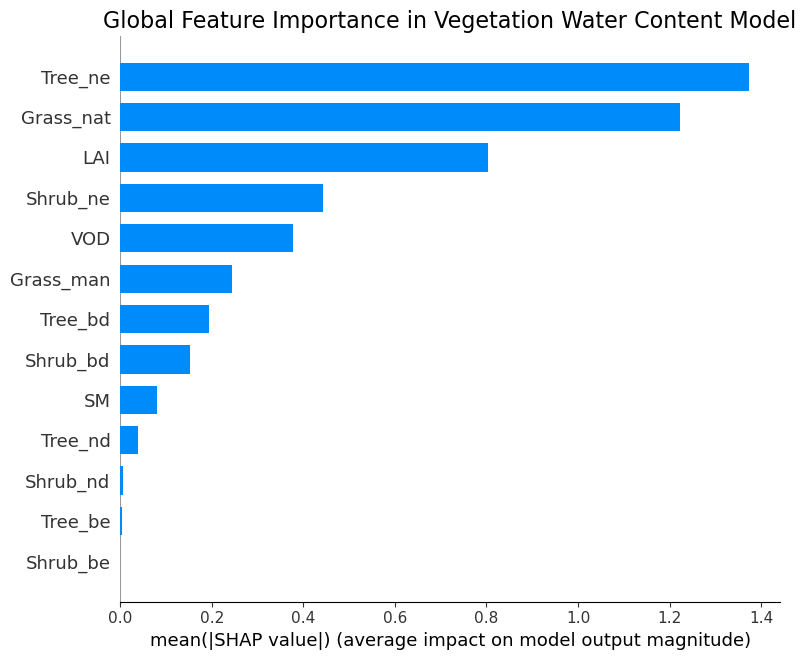

全局特征重要性已保存


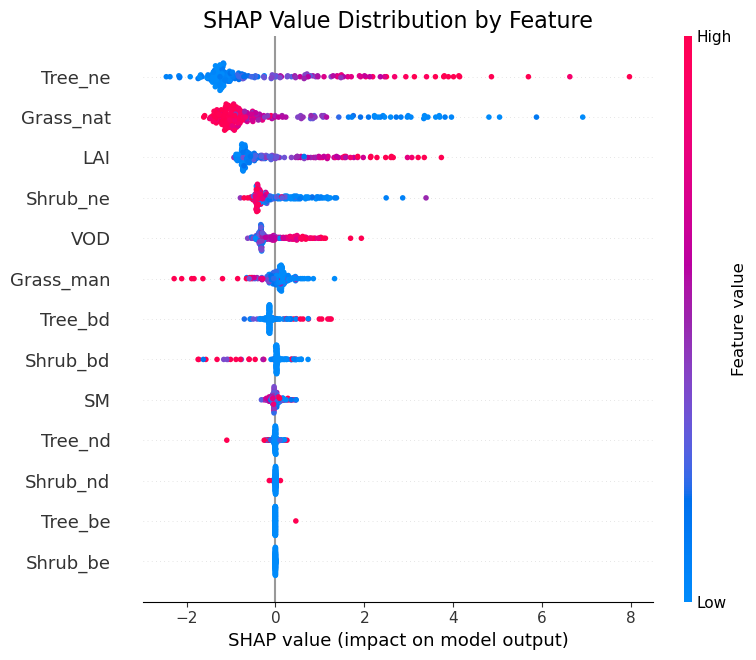

SHAP值分布图已保存


<Figure size 1000x600 with 0 Axes>

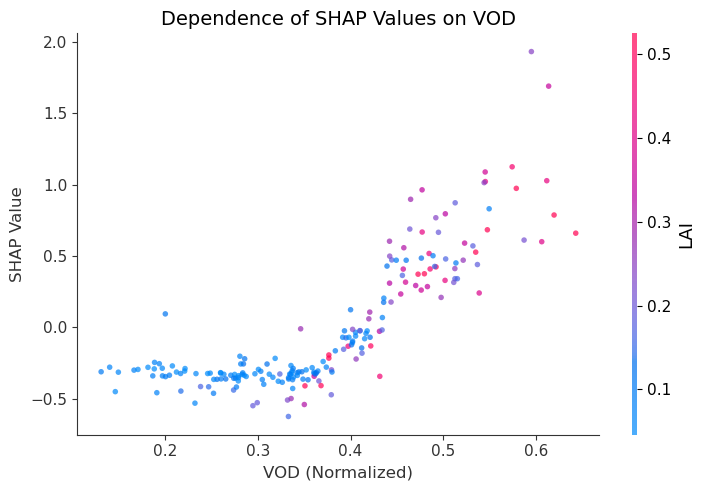

VOD特征依赖图已保存


<Figure size 1000x600 with 0 Axes>

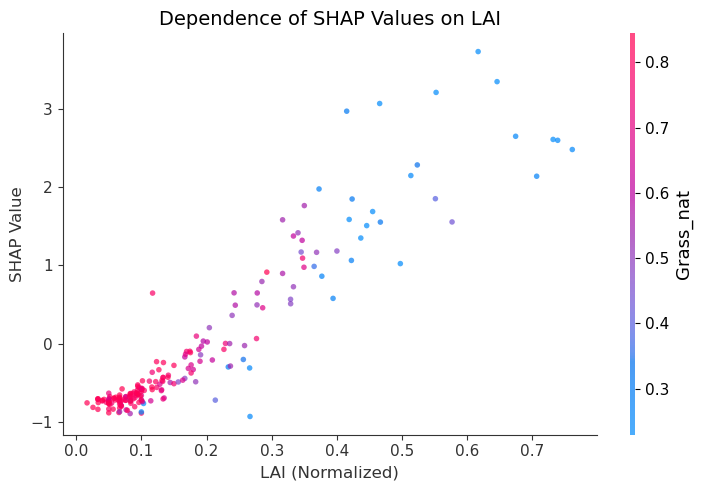

LAI特征依赖图已保存


<Figure size 1000x600 with 0 Axes>

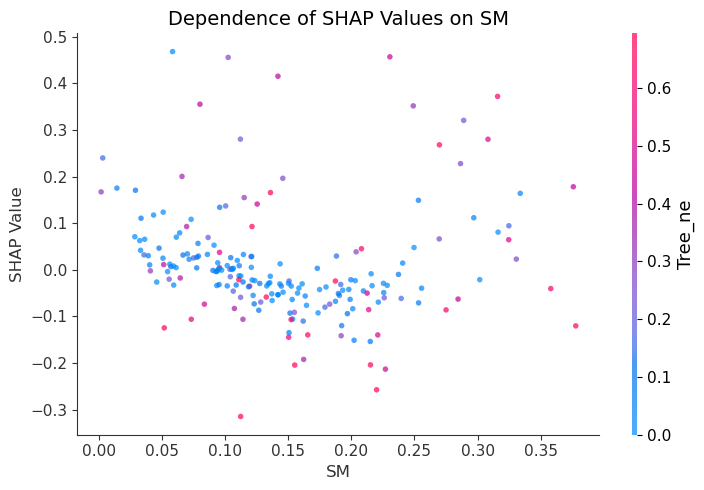

In [ ]:
# VOD_Ku_Hpol_Asc_Cleaned_Type1
import shap
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import joblib
import os

# 创建保存图像的目录
os.makedirs("shapPics", exist_ok=True)

# 1. 加载训练好的模型
model_path = "models/RFR_Ku_Hpol_Type1.pkl"
rf_model = joblib.load(model_path)
print(f"模型已成功加载: {type(rf_model).__name__}")

# 2. 加载特征数据集
def load_and_preprocess_features():
    """
    加载特征数据集并应用与训练时完全相同的预处理
    返回特征矩阵DataFrame和目标变量Series
    """    
    # 原始数据路径（应与训练时一致）
    file_path = r"E:\Matlab\EX2025\AuxiliaryData\VWC_ML_Data.xlsx"
    sheet_name = "VOD_Ku_Hpol_Asc_Cleaned_Type1"
    
    # 需要提取的列（与训练时相同）
    columns_to_extract = [
        'AGB', 'SM_Asc', 'Grass_man', 'Grass_nat',
        'Shrub_bd', 'Shrub_be', 'Shrub_nd', 'Shrub_ne',
        'Tree_bd', 'Tree_be', 'Tree_nd', 'Tree_ne',
        'LAI', 'LFMCValue', 'VOD_Ku_Hpol_Asc', 'SamplingDate'
    ]
    
    # 读取数据
    try:
        df = pd.read_excel(file_path, sheet_name=sheet_name, usecols=columns_to_extract)
    except Exception as e:
        print(f"数据加载失败: {str(e)}")
        return None, None
    
    # 移除缺失值
    df = df.dropna()
    
    # 复现与训练时完全相同的预处理流程
    # 步骤①：计算 VWC_sample
    df['VWC_sample'] = (df['AGB'] * df['LFMCValue']) / 1000
    df.drop(['AGB', 'LFMCValue'], axis=1, inplace=True)
    
    # 步骤②：提取年份差
    df['Year_diff'] = df['SamplingDate'].dt.year.apply(lambda x: 2020 - x)
    
    # 步骤③：归一化 LAI（范围 0-6）
    df['LAI'] = df['LAI'].clip(0, 6) / 6
    
    # 步骤④：归一化 VOD_Ku_Hpol_Asc（范围 0-2），改名为 VOD
    df['VOD'] = df['VOD_Ku_Hpol_Asc'].clip(0, 2) / 2
    df.drop(['VOD_Ku_Hpol_Asc'], axis=1, inplace=True)
    
    # 重命名SM列（与训练时一致）
    df = df.rename(columns={'SM_Asc': 'SM'})
    
    # 定义最终特征列（与训练时相同）
    feature_columns = [
        'VOD', 'LAI', 'SM',
        'Grass_man', 'Grass_nat',
        'Shrub_bd', 'Shrub_be', 'Shrub_nd', 'Shrub_ne',
        'Tree_bd', 'Tree_be', 'Tree_nd', 'Tree_ne'
    ]
    
    # 提取特征矩阵和目标变量
    X = df[feature_columns]
    y = df['VWC_sample']
    
    # 移除训练时不用的列（与训练时相同）
    X = X.drop(columns=['SamplingDate', 'Year_diff'], errors='ignore')
    
    return X, y

# 加载特征数据集
X_df, y_true = load_and_preprocess_features()

# 3. 创建SHAP解释器
explainer = shap.TreeExplainer(rf_model)

# 4. 计算SHAP值（选择200个样本可视化，避免内存问题）
sample_size = min(200, len(X_df))
sample_indices = np.random.choice(X_df.index, size=sample_size, replace=False)
X_sample = X_df.iloc[sample_indices]

shap_values = explainer.shap_values(X_sample)
expected_value = explainer.expected_value
print("SHAP值计算完成")

# 5. 分别生成并保存所有SHAP图（使用原始特征名称）

# 5.1 全局特征重要性图（条形图）
plt.figure(figsize=(12, 8))
shap.summary_plot(shap_values, X_sample, plot_type="bar", show=False)
plt.title("Global Feature Importance in Vegetation Water Content Model", fontsize=16)
plt.tight_layout()
plt.savefig("shapPics/feature_importance_Ku_Hpol_Type1.png", dpi=300, bbox_inches='tight')
plt.show()
print("全局特征重要性已保存")

# 5.2 SHAP摘要点图（特征影响分布）
plt.figure(figsize=(14, 8))
shap.summary_plot(shap_values, X_sample, show=False)
plt.title("SHAP Value Distribution by Feature", fontsize=16)
plt.tight_layout()
plt.savefig("shapPics/shap_value_distribution_Ku_Hpol_Type1.png", dpi=300, bbox_inches='tight')
plt.show()
print("SHAP值分布图已保存")

# 5.3 VOD特征依赖图
plt.figure(figsize=(10, 6))
shap.dependence_plot("VOD", shap_values, X_sample, interaction_index="auto", 
                   show=False, dot_size=16, alpha=0.7)
plt.title("Dependence of SHAP Values on VOD", fontsize=14)
plt.xlabel("VOD (Normalized)", fontsize=12)
plt.ylabel("SHAP Value", fontsize=12)
plt.tight_layout()
plt.savefig("shapPics/vod_dependence_Ku_Hpol_Type1.png", dpi=300, bbox_inches='tight')
plt.show()
print("VOD特征依赖图已保存")

# 5.4 LAI特征依赖图
plt.figure(figsize=(10, 6))
shap.dependence_plot("LAI", shap_values, X_sample, interaction_index="auto", 
                   show=False, dot_size=16, alpha=0.7)
plt.title("Dependence of SHAP Values on LAI", fontsize=14)
plt.xlabel("LAI (Normalized)", fontsize=12)
plt.ylabel("SHAP Value", fontsize=12)
plt.tight_layout()
plt.savefig("shapPics/lai_dependence_Ku_Hpol_Type1.png", dpi=300, bbox_inches='tight')
plt.show()
print("LAI特征依赖图已保存")

# 5.5 SM特征依赖图
plt.figure(figsize=(10, 6))
shap.dependence_plot("SM", shap_values, X_sample, interaction_index="auto", 
                   show=False, dot_size=16, alpha=0.7)
plt.title("Dependence of SHAP Values on SM", fontsize=14)
plt.xlabel("SM", fontsize=12)
plt.ylabel("SHAP Value", fontsize=12)
plt.tight_layout()
plt.savefig("shapPics/sm_dependence_Ku_Hpol_Type1.png", dpi=300, bbox_inches='tight')
plt.show()
print("SM特征依赖图已保存")


# # 6. 交互作用分析（可选）
# shap_interaction_values = explainer.shap_interaction_values(X_sample)
    
# # 6.1 交互作用热力图（主要特征）
# plt.figure(figsize=(15, 12))
# shap.summary_plot(shap_interaction_values, X_sample, max_display=8, show=False)
# plt.title("Feature Interaction Values in Vegetation Model", fontsize=16)
# plt.tight_layout()
# plt.savefig("shapPics/feature_interactions_Ku_Hpol_Type1.png", dpi=300, bbox_inches='tight')
# plt.show()
# print("特征交互热力图已保存")


# 绘制：每个模型的SHAP摘要点图（在训练集选择500个点进行可视化）、交互值依赖性图，二者均拼接为3*3的子图形式


交互值依赖性图示例：
shap.dependence_plot(
    ("Age", "Age"),
    shap_interaction_values, X.iloc[:2000,:],
    display_features=X_display.iloc[:2000,:]
)

In [1]:
# summary plot
import shap
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import joblib
import os
import random
import warnings
from sklearn.model_selection import train_test_split

# 设置随机种子保证可重复性
SEED = 42
random.seed(SEED)
np.random.seed(SEED)

# 定义波段和极化组合
BANDS = ['Ku', 'X', 'C']
POLS = ['H', 'V', 'HV']

# 创建保存图像的目录
os.makedirs("shapPics", exist_ok=True)

# 过滤警告
warnings.filterwarnings("ignore")

def load_data_for_model(band, pol):
    """根据波段和极化加载并预处理数据"""
    # 根据极化类型确定文件路径
    if pol == 'HV':
        file_path = r"E:\Matlab\EX2025\AuxiliaryData\VWC_DualPol_ML_Data.xlsx"
    else:
        file_path = r"E:\Matlab\EX2025\AuxiliaryData\VWC_ML_Data.xlsx"
    
    # 确定sheet名称
    sheet_name = f"VOD_{band}_{pol}pol_Asc_Cleaned_Type1"
    
    # 定义基础列名
    base_columns = [
        'AGB', 'SM_Asc', 'Grass_man', 'Grass_nat',
        'Shrub_bd', 'Shrub_be', 'Shrub_nd', 'Shrub_ne',
        'Tree_bd', 'Tree_be', 'Tree_nd', 'Tree_ne',
        'LAI', 'LFMCValue', 'SamplingDate'
    ]
    
    # 根据极化情况添加相应的VOD列
    if pol == 'H':
        vod_columns = [f'VOD_{band}_Hpol_Asc']
    elif pol == 'V':
        vod_columns = [f'VOD_{band}_Vpol_Asc']
    else:  # HV
        vod_columns = [f'VOD_{band}_Hpol_Asc', f'VOD_{band}_Vpol_Asc']
    
    # 合并所有需要的列
    columns_to_extract = base_columns + vod_columns
    
    try:
        df = pd.read_excel(file_path, sheet_name=sheet_name, usecols=columns_to_extract)
    except Exception as e:
        print(f"数据加载失败: {str(e)}")
        return None, None
    
    # 移除缺失值
    df = df.dropna()
    if df.empty:
        return None, None
    
    # 复现与训练时完全相同的预处理流程
    # 步骤①：计算 VWC_sample
    df['VWC_sample'] = (df['AGB'] * df['LFMCValue']) / 1000
    
    # 步骤②：过滤VWC_sample > 30
    df = df[df['VWC_sample'] <= 30]
    if df.empty:
        return None, None
    
    # 步骤③：创建年份差列
    df['Year_diff'] = df['SamplingDate'].dt.year.apply(lambda x: 2020 - x)
    
    # 步骤④：归一化处理
    df['LAI'] = df['LAI'].clip(0, 6) / 6
    
    # 重命名SM列
    df = df.rename(columns={'SM_Asc': 'SM'})
    
    # 根据极化情况处理VOD列
    if pol == 'H':
        df['VOD'] = df[f'VOD_{band}_Hpol_Asc'].clip(0, 2) / 2
        df.drop(vod_columns, axis=1, inplace=True)
        feature_columns = ['VOD', 'LAI', 'SM'] + base_columns[2:-4]
    elif pol == 'V':
        df['VOD'] = df[f'VOD_{band}_Vpol_Asc'].clip(0, 2) / 2
        df.drop(vod_columns, axis=1, inplace=True)
        feature_columns = ['VOD', 'LAI', 'SM'] + base_columns[2:-4]
    else:  # HV
        df['VOD-Hpol'] = df[f'VOD_{band}_Hpol_Asc'].clip(0, 2) / 2
        df['VOD-Vpol'] = df[f'VOD_{band}_Vpol_Asc'].clip(0, 2) / 2
        df.drop(vod_columns, axis=1, inplace=True)
        feature_columns = ['VOD-Hpol', 'VOD-Vpol', 'LAI', 'SM'] + base_columns[2:-4]
    
    # 提取特征矩阵和目标变量
    X = df[feature_columns]
    y = df['VWC_sample']
    
    # 移除训练时不用的列
    X = X.drop(columns=['SamplingDate', 'Year_diff'], errors='ignore')
    
    return X, y

# 遍历所有波段和极化组合
for band in BANDS:
    for pol in POLS:
        print(f"\n开始处理: {band}波段, {pol}极化")
        
        try:
            # 构建模型路径
            model_path = f"models/RFR_{band}_{pol}pol_Type1.pkl"
            
            # 加载随机森林模型
            rf_model = joblib.load(model_path)
            print(f"成功加载模型: {band}波段, {pol}极化 - {type(rf_model).__name__}")
            
            # 加载特征数据集
            X_df, y_true = load_data_for_model(band, pol)
            
            if X_df is None or y_true is None:
                print(f"数据加载失败或预处理后无有效样本: {band}-{pol}")
                continue
            
            # 数据划分 (训练集：测试集=2：1)
            X_train, X_test, y_train, y_test = train_test_split(
                X_df, y_true, 
                test_size=0.333, 
                random_state=SEED,
                shuffle=True
            )
            
            # 从训练集中随机抽取少量样本 (减少内存使用)
            sample_size = min(200, len(X_train))
            sample_indices = np.random.choice(
                X_train.index, 
                size=sample_size, 
                replace=False
            )
            X_sample = X_train.loc[sample_indices]
            
            # 使用最简单的TreeExplainer计算SHAP值
            try:
                explainer = shap.TreeExplainer(rf_model)
                shap_values = explainer.shap_values(X_sample, check_additivity=False)
                print(f"成功计算SHAP值，样本量: {sample_size}")
            except Exception as e:
                print(f"SHAP计算失败: {str(e)}")
                continue
            
            # 为每个组合创建独立图表
            plt.figure(figsize=(10, 8))
            
            # 绘制SHAP摘要点图
            shap.summary_plot(
                shap_values, 
                X_sample, 
                plot_type="dot", 
                show=False,
                max_display=10,
                color_bar=True
            )
            
            # 添加标题
            plt.title(f'SHAP Summary: {band} Band, {pol} Pol', fontsize=14)
            plt.tight_layout()
            
            # 保存单独图片
            plot_filename = f"shapPics/summary_{band}_{pol}.png"
            plt.savefig(plot_filename, bbox_inches='tight', dpi=150)
            plt.close()
            print(f"已保存summary plot: {plot_filename}")
            
        except Exception as e:
            print(f"处理{band}-{pol}时出错: {str(e)}")

print("\n全部处理完成！")


开始处理: Ku波段, H极化
成功加载模型: Ku波段, H极化 - RandomForestRegressor
成功计算SHAP值，样本量: 200
已保存summary plot: shapPics/summary_Ku_H.png

开始处理: Ku波段, V极化
成功加载模型: Ku波段, V极化 - RandomForestRegressor
成功计算SHAP值，样本量: 200
已保存summary plot: shapPics/summary_Ku_V.png

开始处理: Ku波段, HV极化
成功加载模型: Ku波段, HV极化 - RandomForestRegressor
成功计算SHAP值，样本量: 200
已保存summary plot: shapPics/summary_Ku_HV.png

开始处理: X波段, H极化
成功加载模型: X波段, H极化 - RandomForestRegressor
成功计算SHAP值，样本量: 200
已保存summary plot: shapPics/summary_X_H.png

开始处理: X波段, V极化
成功加载模型: X波段, V极化 - RandomForestRegressor
成功计算SHAP值，样本量: 200
已保存summary plot: shapPics/summary_X_V.png

开始处理: X波段, HV极化
成功加载模型: X波段, HV极化 - RandomForestRegressor
成功计算SHAP值，样本量: 200
已保存summary plot: shapPics/summary_X_HV.png

开始处理: C波段, H极化
成功加载模型: C波段, H极化 - RandomForestRegressor
成功计算SHAP值，样本量: 200
已保存summary plot: shapPics/summary_C_H.png

开始处理: C波段, V极化
成功加载模型: C波段, V极化 - RandomForestRegressor
成功计算SHAP值，样本量: 200
已保存summary plot: shapPics/summary_C_V.png

开始处理: C波段, HV极化
成功加载模型: C波段, HV极化 - Rand

找到 9 张图片，准备拼接...
最大单图尺寸: 1134x808 像素
已添加标题
已拼接图片 1/9: shapPics\summary_Ku_H.png -> 位置 (0, 110)
已拼接图片 2/9: shapPics\summary_Ku_V.png -> 位置 (1134, 110)
已拼接图片 3/9: shapPics\summary_Ku_HV.png -> 位置 (2268, 110)
已拼接图片 4/9: shapPics\summary_X_H.png -> 位置 (0, 918)
已拼接图片 5/9: shapPics\summary_X_V.png -> 位置 (1134, 918)
已拼接图片 6/9: shapPics\summary_X_HV.png -> 位置 (2268, 918)
已拼接图片 7/9: shapPics\summary_C_H.png -> 位置 (0, 1726)
已拼接图片 8/9: shapPics\summary_C_V.png -> 位置 (1134, 1726)
已拼接图片 9/9: shapPics\summary_C_HV.png -> 位置 (2268, 1726)

组合图已保存: shapPics/summary_combined_grid.png


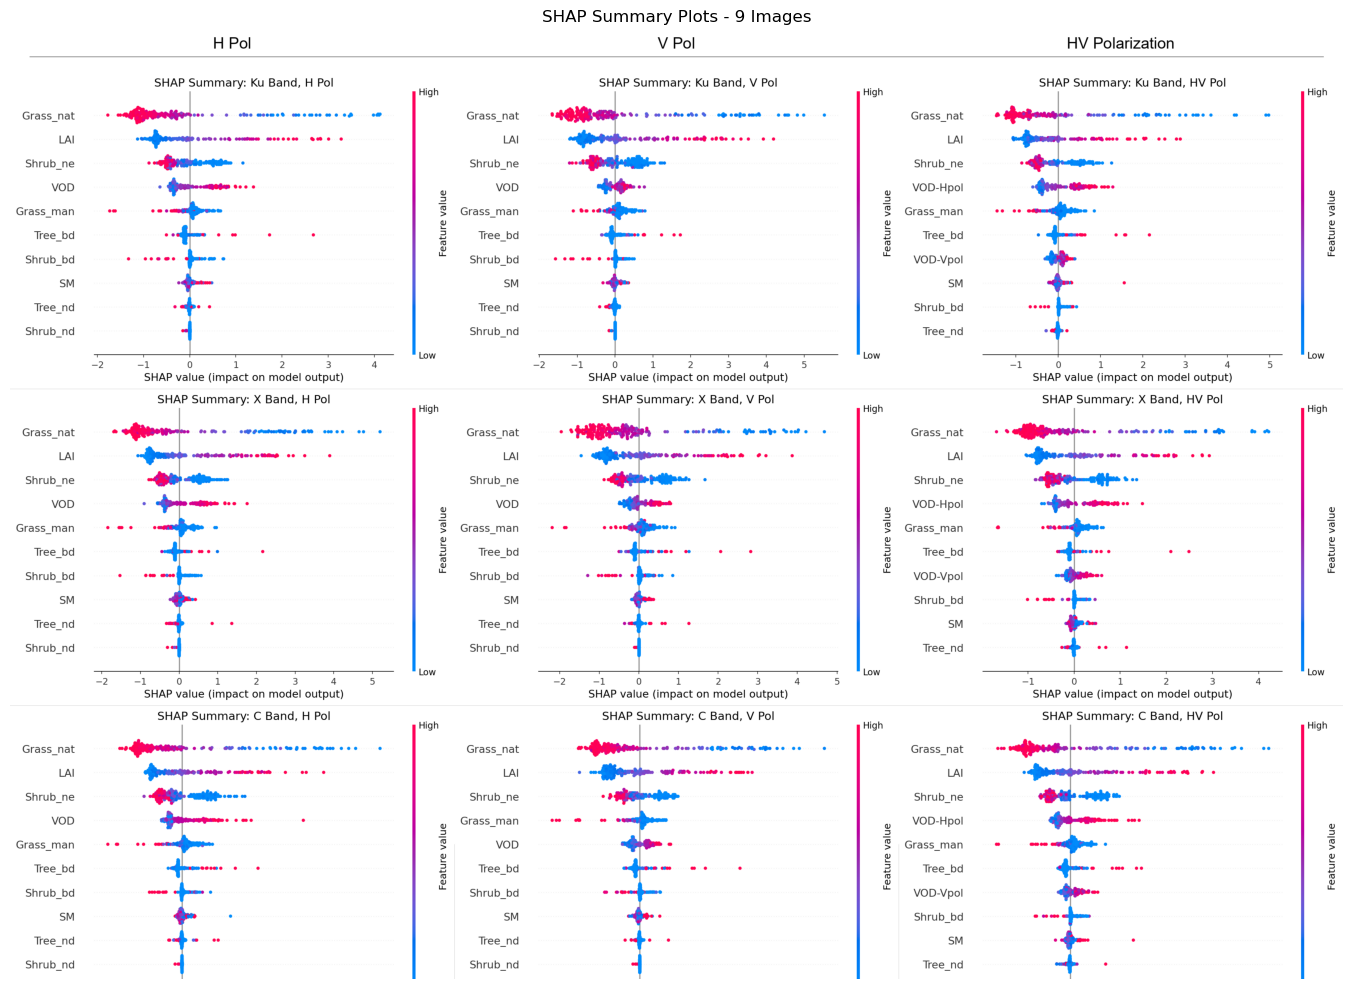

操作成功完成!


In [2]:
import os
import numpy as np
from PIL import Image, ImageDraw, ImageFont
import matplotlib.pyplot as plt

# 配置参数
BANDS = ['Ku', 'X', 'C']
POLS = ['H', 'V', 'HV']
INPUT_DIR = "shapPics"  # 存放单独图片的目录
OUTPUT_FILE = "shapPics/summary_combined_grid.png"  # 输出的组合图文件名

def create_combined_grid():
    """将所有波段-极化组合的summary plot组合成3x3网格图"""
    # 确保输入目录存在
    if not os.path.exists(INPUT_DIR):
        print(f"错误: 输入目录 {INPUT_DIR} 不存在!")
        return False
    
    # 收集所有图片路径
    image_paths = []
    valid_images = []
    
    for band in BANDS:
        for pol in POLS:
            file_path = os.path.join(INPUT_DIR, f"summary_{band}_{pol}.png")
            if os.path.exists(file_path):
                image_paths.append(file_path)
                valid_images.append((band, pol))
            else:
                print(f"警告: 图片缺失 {band}-{pol}")
    
    if not image_paths:
        print("错误: 没有找到任何图片!")
        return False
    
    print(f"找到 {len(image_paths)} 张图片，准备拼接...")
    
    # 确定网格布局（3行×3列）
    nrows = len(BANDS)
    ncols = len(POLS)
    
    # 计算组合图的尺寸
    max_width = 0
    max_height = 0
    
    # 获取最大图片尺寸
    for img_path in image_paths:
        img = Image.open(img_path)
        max_width = max(max_width, img.width)
        max_height = max(max_height, img.height)
    
    print(f"最大单图尺寸: {max_width}x{max_height} 像素")
    
    # 创建组合图画布
    grid_width = max_width * ncols
    grid_height = max_height * nrows
    combined_img = Image.new('RGB', (grid_width, grid_height), (255, 255, 255))
    
    # 添加标题
    try:
        # 尝试使用系统字体
        font_size = 40
        try:
            font = ImageFont.truetype("arial.ttf", font_size)
        except:
            # 回退到默认字体
            font = ImageFont.load_default()
        
        # 创建标题
        title = ""
        draw = ImageDraw.Draw(combined_img)
        text_width = draw.textlength(title, font=font)
        
        # 计算标题位置（居中）
        title_x = (grid_width - text_width) // 2
        title_y = 20
        
        # 绘制标题
        draw.text((title_x, title_y), title, fill="black", font=font)
        
        # 添加标题下划线
        line_y = title_y + font_size + 10
        draw.line([(50, line_y), (grid_width - 50, line_y)], fill="gray", width=2)
        
        print("已添加标题")
    except Exception as e:
        print(f"标题添加失败: {str(e)}")
    
    # 添加行列标签
    try:
        col_label_y = line_y + 20 if 'line_y' in locals() else 70
        row_label_x = 50
        
        for i, band in enumerate(BANDS):
            # 行标签（波段）
            text = f"{band} Band"
            y_position = col_label_y + i * max_height + max_height // 2
            draw.text((row_label_x - 40, y_position), text, fill="black", font=font, anchor="lm")
        
        for j, pol in enumerate(POLS):
            # 列标签（极化）
            text = f"{pol} Pol" if pol != "HV" else "HV Pol"
            x_position = max_width * j + max_width // 2
            draw.text((x_position, col_label_y - 40), text, fill="black", font=font, anchor="mb")
    except Exception as e:
        print(f"行列标签添加失败: {str(e)}")
    
    # 拼接所有图片
    for idx, img_path in enumerate(image_paths):
        img = Image.open(img_path)
        
        # 计算位置
        # 按波段确定行索引
        band_idx = BANDS.index(valid_images[idx][0])
        # 按极化确定列索引
        pol_idx = POLS.index(valid_images[idx][1])
        
        # 缩放图片到最大尺寸（保持比例，添加白边）
        if img.width != max_width or img.height != max_height:
            # 创建带白边的新图
            new_img = Image.new("RGB", (max_width, max_height), (255, 255, 255))
            # 计算居中位置
            x_offset = (max_width - img.width) // 2
            y_offset = (max_height - img.height) // 2
            new_img.paste(img, (x_offset, y_offset))
            img = new_img
            print(f"调整图片尺寸: {img_path}")
        
        # 计算位置 (考虑标题空间)
        x = pol_idx * max_width
        y = band_idx * max_height + (line_y + 40 if 'line_y' in locals() else 80)
        
        # 粘贴图片
        combined_img.paste(img, (x, y))
        print(f"已拼接图片 {idx+1}/{len(image_paths)}: {img_path} -> 位置 ({x}, {y})")
    
    # 添加网格线
    try:
        draw = ImageDraw.Draw(combined_img)
        # 垂直网格线
        for i in range(1, ncols):
            x = i * max_width
            draw.line([(x, y_position - 30), (x, grid_height)], fill="lightgray", width=1)
        
        # 水平网格线
        for j in range(1, nrows):
            y = j * max_height + (line_y + 40 if 'line_y' in locals() else 80)
            draw.line([(0, y), (grid_width, y)], fill="lightgray", width=1)
    except:
        pass
    
    # 保存最终图片
    combined_img.save(OUTPUT_FILE, quality=95)
    print(f"\n组合图已保存: {OUTPUT_FILE}")
    
    # 显示图片预览
    plt.figure(figsize=(15, 10))
    plt.imshow(np.array(combined_img))
    plt.axis('off')
    plt.title(f"SHAP Summary Plots - {len(image_paths)} Images")
    plt.tight_layout()
    plt.show()
    
    return True

# 执行组合图创建
if __name__ == "__main__":
    success = create_combined_grid()
    if success:
        print("操作成功完成!")
    else:
        print("创建组合图时出现问题")

In [2]:
# VOD 特征依赖性图绘制 - 最终修复版
import shap
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import joblib
import os
import random
import warnings
import traceback
from sklearn.model_selection import train_test_split

# 设置随机种子保证可重复性
SEED = 42
random.seed(SEED)
np.random.seed(SEED)

# 定义波段和极化组合
# BANDS = ['Ku', 'X', 'C']
BANDS = 'C'
POLS = ['H', 'V', 'HV']

# 创建保存图像的目录
os.makedirs("vod_dependence", exist_ok=True)

# 过滤警告
warnings.filterwarnings("ignore")

def load_data_for_model(band, pol):
    """根据波段和极化加载并预处理数据"""
    # 根据极化类型确定文件路径
    if pol == 'HV':
        file_path = r"E:\Matlab\EX2025\AuxiliaryData\VWC_DualPol_ML_Data.xlsx"
    else:
        file_path = r"E:\Matlab\EX2025\AuxiliaryData\VWC_ML_Data.xlsx"
    
    # 确定sheet名称
    sheet_name = f"VOD_{band}_{pol}pol_Asc_Cleaned_Type1"
    
    # 定义基础列名
    base_columns = [
        'AGB', 'SM_Asc', 'Grass_man', 'Grass_nat',
        'Shrub_bd', 'Shrub_be', 'Shrub_nd', 'Shrub_ne',
        'Tree_bd', 'Tree_be', 'Tree_nd', 'Tree_ne',
        'LAI', 'LFMCValue', 'SamplingDate'
    ]
    
    # 根据极化情况添加相应的VOD列
    if pol == 'H':
        vod_columns = [f'VOD_{band}_Hpol_Asc']
    elif pol == 'V':
        vod_columns = [f'VOD_{band}_Vpol_Asc']
    else:  # HV
        vod_columns = [f'VOD_{band}_Hpol_Asc', f'VOD_{band}_Vpol_Asc']
    
    # 合并所有需要的列
    columns_to_extract = base_columns + vod_columns
    
    try:
        df = pd.read_excel(file_path, sheet_name=sheet_name, usecols=columns_to_extract)
    except Exception as e:
        print(f"数据加载失败: {str(e)}")
        return None, None, None
    
    # 移除缺失值
    df = df.dropna()
    if df.empty:
        return None, None, None
    
    # 复现与训练时完全相同的预处理流程
    # 步骤①：计算 VWC_sample
    df['VWC_sample'] = (df['AGB'] * df['LFMCValue']) / 1000
    
    # 步骤②：过滤VWC_sample > 30
    df = df[df['VWC_sample'] <= 30]
    if df.empty:
        return None, None, None
    
    # 步骤③：创建年份差列
    df['Year_diff'] = df['SamplingDate'].dt.year.apply(lambda x: 2020 - x)
    
    # 步骤④：归一化处理
    df['LAI'] = df['LAI'].clip(0, 6) / 6
    
    # 重命名SM列
    df = df.rename(columns={'SM_Asc': 'SM'})
    
    # 存储原始VOD值（裁剪至0-2范围）
    vod_raw_values = {}
    
    # 根据极化情况处理VOD列
    if pol == 'H':
        # 保存原始VOD值（裁剪至0-2范围）
        vod_raw = df[f'VOD_{band}_Hpol_Asc'].clip(0, 2)
        vod_raw_values['VOD'] = vod_raw
        
        # 归一化处理
        df['VOD'] = vod_raw / 2
        df.drop(vod_columns, axis=1, inplace=True)
        feature_columns = ['VOD', 'LAI', 'SM'] + base_columns[2:-4]
    elif pol == 'V':
        # 保存原始VOD值（裁剪至0-2范围）
        vod_raw = df[f'VOD_{band}_Vpol_Asc'].clip(0, 2)
        vod_raw_values['VOD'] = vod_raw
        
        # 归一化处理
        df['VOD'] = vod_raw / 2
        df.drop(vod_columns, axis=1, inplace=True)
        feature_columns = ['VOD', 'LAI', 'SM'] + base_columns[2:-4]
    else:  # HV
        # 保存原始VOD值（裁剪至0-2范围）
        vod_raw_h = df[f'VOD_{band}_Hpol_Asc'].clip(0, 2)
        vod_raw_v = df[f'VOD_{band}_Vpol_Asc'].clip(0, 2)
        vod_raw_values['VOD-Hpol'] = vod_raw_h
        vod_raw_values['VOD-Vpol'] = vod_raw_v
        
        # 归一化处理
        df['VOD-Hpol'] = vod_raw_h / 2
        df['VOD-Vpol'] = vod_raw_v / 2
        df.drop(vod_columns, axis=1, inplace=True)
        feature_columns = ['VOD-Hpol', 'VOD-Vpol', 'LAI', 'SM'] + base_columns[2:-4]
    
    # 提取特征矩阵和目标变量
    X = df[feature_columns]
    y = df['VWC_sample']
    
    # 移除训练时不用的列
    X = X.drop(columns=['SamplingDate', 'Year_diff'], errors='ignore')
    
    # 创建原始VOD值的DataFrame - 用于display_features
    vod_display = pd.DataFrame()
    for col in vod_raw_values:
        vod_display[col] = vod_raw_values[col]
    
    # 打印特征信息用于调试
    print(f"  预处理后特征列: {X.columns.tolist()}")
    print(f"  原始VOD值列: {vod_display.columns.tolist()}")
    
    return X, y, vod_display

# 遍历所有波段和极化组合
for band in BANDS:
    for pol in POLS:
        print(f"\n开始处理: {band}波段, {pol}极化")
        
        try:
            # 构建模型路径
            model_path = f"models/RFR_{band}_{pol}pol_Type1.pkl"
            
            # 加载随机森林模型
            rf_model = joblib.load(model_path)
            print(f"成功加载模型: {band}波段, {pol}极化 - {type(rf_model).__name__}")
            
            # 加载特征数据集和原始VOD值
            X_df, y_true, vod_display_df = load_data_for_model(band, pol)
            
            if X_df is None or y_true is None or vod_display_df is None:
                print(f"数据加载失败或预处理后无有效样本: {band}-{pol}")
                continue
            
            # 数据划分 (训练集：测试集=2：1) - 使用相同随机种子
            X_train, X_test, y_train, y_test = train_test_split(
                X_df, y_true, 
                test_size=0.333, 
                random_state=SEED,
                shuffle=True
            )
            
            # 关键修复：直接使用训练集索引获取原始VOD值
            vod_display_train = vod_display_df.loc[X_train.index]
            
            # 确保vod_display_train是DataFrame
            if isinstance(vod_display_train, pd.Series):
                # 如果是单列，转换为DataFrame并保留列名
                col_name = vod_display_df.columns[0]
                vod_display_train = pd.DataFrame({col_name: vod_display_train})
            elif not isinstance(vod_display_train, pd.DataFrame):
                print(f"! vod_display_train 不是DataFrame: {type(vod_display_train)}")
                continue
            
            # 打印列名用于调试
            print(f"  vod_display_train列名: {vod_display_train.columns.tolist()}")
            
            # 从训练集中随机抽取样本 - 使用相同随机种子和样本量
            sample_size = min(200, len(X_train))
            rng = np.random.RandomState(SEED)  # 使用相同随机状态生成器
            sample_indices = rng.choice(
                X_train.index, 
                size=sample_size, 
                replace=False
            )
            X_sample = X_train.loc[sample_indices]
            
            # 使用相同的TreeExplainer计算SHAP值
            try:
                explainer = shap.TreeExplainer(rf_model)
                shap_values = explainer.shap_values(X_sample, check_additivity=False)
                print(f"成功计算SHAP值，样本量: {sample_size}")
            except Exception as e:
                print(f"SHAP计算失败: {str(e)}")
                continue
            
            # 确定VOD特征名称 - 使用实际列名
            vod_features = vod_display_train.columns.tolist()
            print(f"  将绘制的VOD特征: {vod_features}")
            
            # 为每个VOD特征绘制依赖性图
            for vod_feature in vod_features:
                # 检查特征是否存在于X_sample中
                if vod_feature not in X_sample.columns:
                    print(f"! 特征 '{vod_feature}' 不存在于X_sample数据中")
                    print(f"  X_sample列名: {X_sample.columns.tolist()}")
                    continue
                
                # 获取特征索引
                feature_idx = list(X_sample.columns).index(vod_feature)
                
                # 获取原始VOD值（裁剪至0-2范围）
                vod_raw_values = vod_display_train.loc[sample_indices, vod_feature].values
                
                # 获取SHAP值
                if isinstance(shap_values, list):
                    # 对于分类问题，取第一组（回归通常是第一个）
                    shap_vals = shap_values[0][:, feature_idx]
                else:
                    shap_vals = shap_values[:, feature_idx]
                
                # 创建依赖性图
                plt.figure(figsize=(10, 8))
                
                # 绘制散点图 - 使用原始VOD值
                scatter = plt.scatter(
                    vod_raw_values,  # 使用原始VOD值（0-2范围）
                    shap_vals,
                    c=shap_vals,
                    cmap='coolwarm',
                    alpha=0.7,
                    s=30,
                    edgecolor='w',
                    linewidth=0.5
                )
                
                # 添加颜色条
                cbar = plt.colorbar(scatter)
                cbar.set_label('SHAP Value', fontsize=12)
                
                # 设置标签和标题
                plt.xlabel(f'VOD', fontsize=14)
                plt.ylabel('SHAP Value (Impact on VWC)', fontsize=14)
                plt.title(f'VOD Dependence: {band} Band, {pol} Pol', fontsize=16)
                
                # 添加网格
                plt.grid(alpha=0.2, linestyle='--')
                
                # 保存图片
                plot_filename = f"vod_dependence/dependence_{band}_{pol}_{vod_feature.replace('-', '_')}.png"
                plt.tight_layout()
                plt.savefig(plot_filename, dpi=300, bbox_inches='tight')
                plt.close()
                print(f"已保存VOD依赖性图: {plot_filename}")
            
        except Exception as e:
            print(f"处理{band}-{pol}时出错: {str(e)}")
            print(traceback.format_exc())

print("\n全部处理完成！")


开始处理: C波段, H极化
成功加载模型: C波段, H极化 - RandomForestRegressor
  预处理后特征列: ['VOD', 'LAI', 'SM', 'Grass_man', 'Grass_nat', 'Shrub_bd', 'Shrub_be', 'Shrub_nd', 'Shrub_ne', 'Tree_bd', 'Tree_be', 'Tree_nd']
  原始VOD值列: ['VOD']
  vod_display_train列名: ['VOD']
成功计算SHAP值，样本量: 200
  将绘制的VOD特征: ['VOD']
已保存VOD依赖性图: vod_dependence/dependence_C_H_VOD.png

开始处理: C波段, V极化
成功加载模型: C波段, V极化 - RandomForestRegressor
  预处理后特征列: ['VOD', 'LAI', 'SM', 'Grass_man', 'Grass_nat', 'Shrub_bd', 'Shrub_be', 'Shrub_nd', 'Shrub_ne', 'Tree_bd', 'Tree_be', 'Tree_nd']
  原始VOD值列: ['VOD']
  vod_display_train列名: ['VOD']
成功计算SHAP值，样本量: 200
  将绘制的VOD特征: ['VOD']
已保存VOD依赖性图: vod_dependence/dependence_C_V_VOD.png

开始处理: C波段, HV极化
成功加载模型: C波段, HV极化 - RandomForestRegressor
  预处理后特征列: ['VOD-Hpol', 'VOD-Vpol', 'LAI', 'SM', 'Grass_man', 'Grass_nat', 'Shrub_bd', 'Shrub_be', 'Shrub_nd', 'Shrub_ne', 'Tree_bd', 'Tree_be', 'Tree_nd']
  原始VOD值列: ['VOD-Hpol', 'VOD-Vpol']
  vod_display_train列名: ['VOD-Hpol', 'VOD-Vpol']
成功计算SHAP值，样本量: 200
  将绘制的VOD特

找到 12 张依赖图，准备拼接...
最大单图尺寸: 2893x2364 像素
已拼接图片: Ku波段 H极化 -> 位置 (0, 90)
已拼接图片: Ku波段 V极化 -> 位置 (2893, 90)
已拼接图片: Ku波段 HV-H极化 -> 位置 (5786, 90)
已拼接图片: Ku波段 HV-V极化 -> 位置 (8679, 90)
已拼接图片: X波段 H极化 -> 位置 (0, 2454)
已拼接图片: X波段 V极化 -> 位置 (2893, 2454)
已拼接图片: X波段 HV-H极化 -> 位置 (5786, 2454)
已拼接图片: X波段 HV-V极化 -> 位置 (8679, 2454)
已拼接图片: C波段 H极化 -> 位置 (0, 4818)
已拼接图片: C波段 V极化 -> 位置 (2893, 4818)
已拼接图片: C波段 HV-H极化 -> 位置 (5786, 4818)
已拼接图片: C波段 HV-V极化 -> 位置 (8679, 4818)

组合图已保存: vod_dependence/combined_dependence_grid.png


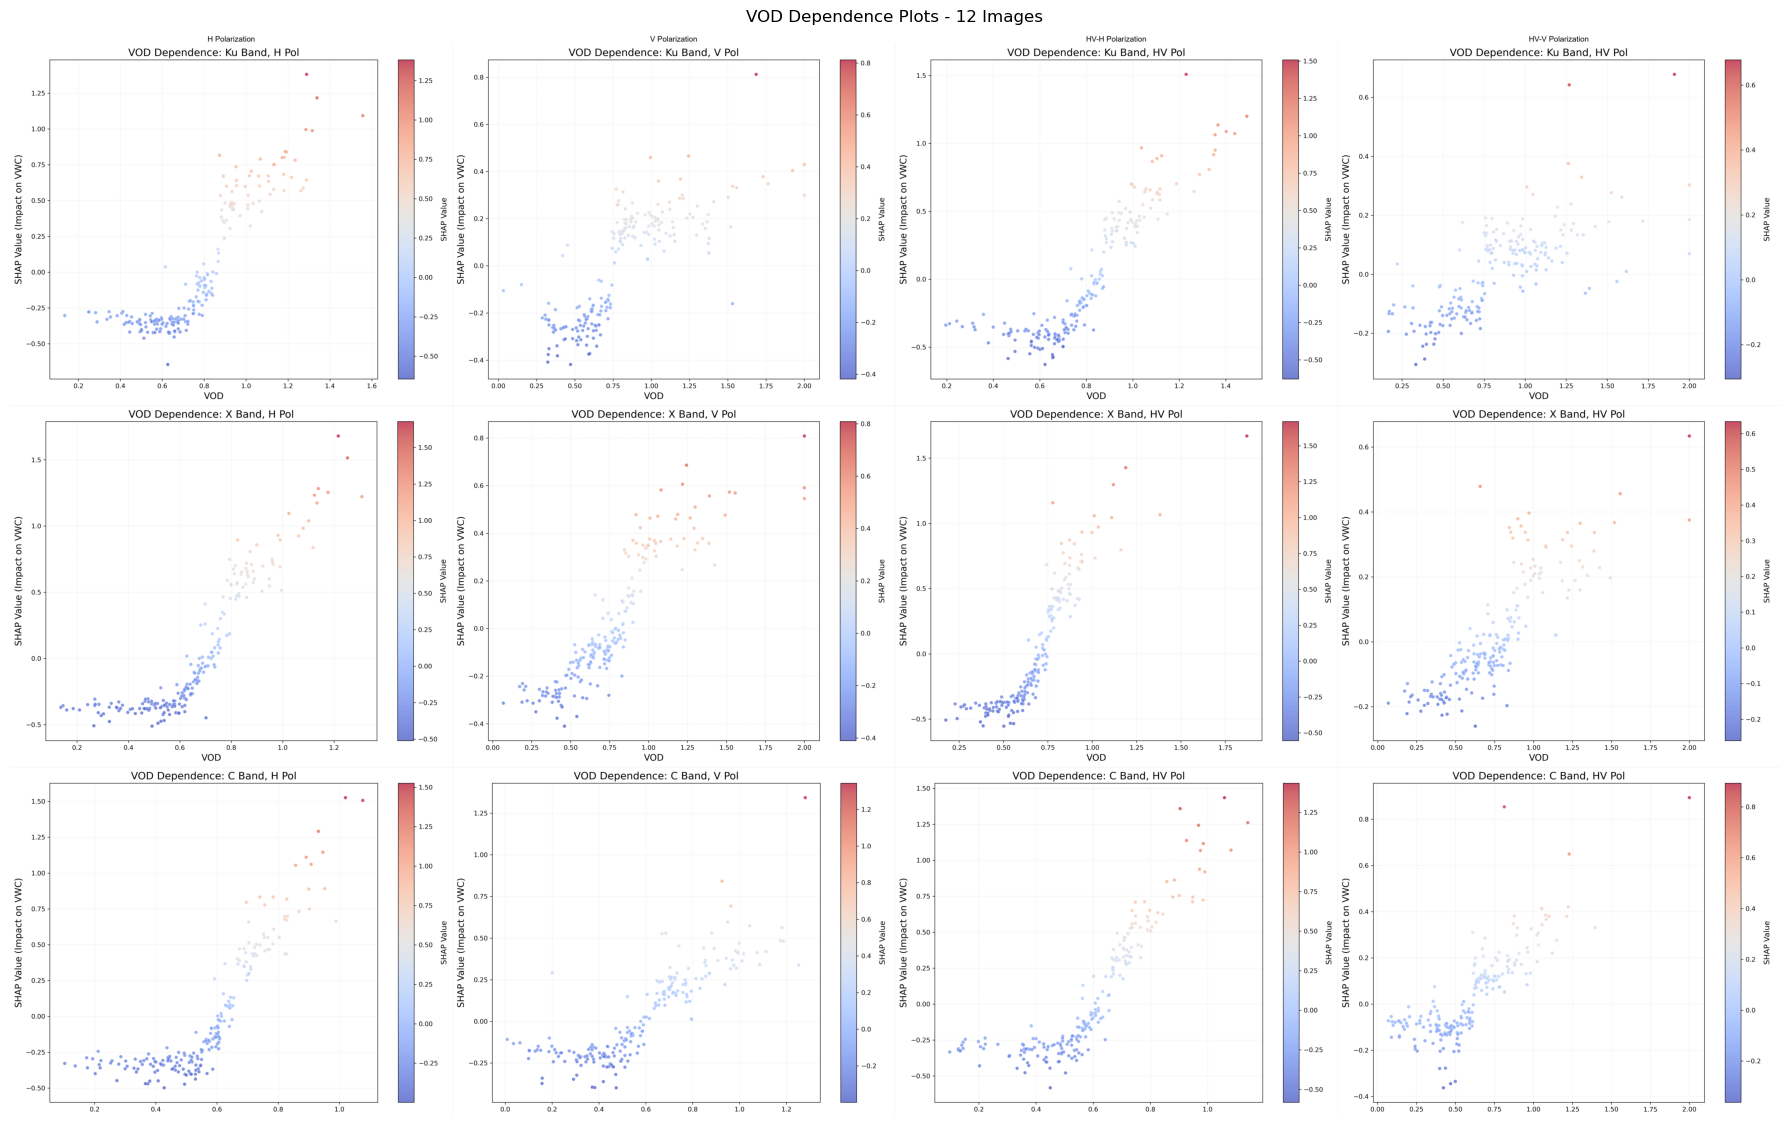

操作成功完成!


In [4]:
import os
import numpy as np
from PIL import Image, ImageDraw, ImageFont
import matplotlib.pyplot as plt

# 配置参数
BANDS = ['Ku', 'X', 'C']
POLS = ['H', 'V', 'HV']
INPUT_DIR = "vod_dependence"  # 存放依赖图的目录
OUTPUT_FILE = "vod_dependence/combined_dependence_grid.png"  # 输出的组合图文件名

def create_combined_grid():
    """将所有波段-极化组合的依赖图组合成3行4列网格图"""
    # 确保输入目录存在
    if not os.path.exists(INPUT_DIR):
        print(f"错误: 输入目录 {INPUT_DIR} 不存在!")
        return False
    
    # 收集所有图片路径
    image_paths = {}
    
    for band in BANDS:
        # H极化图
        h_path = os.path.join(INPUT_DIR, f"dependence_{band}_H_VOD.png")
        if os.path.exists(h_path):
            image_paths[(band, 'H')] = h_path
        else:
            print(f"警告: H极化图片缺失 {band}-H")
        
        # V极化图
        v_path = os.path.join(INPUT_DIR, f"dependence_{band}_V_VOD.png")
        if os.path.exists(v_path):
            image_paths[(band, 'V')] = v_path
        else:
            print(f"警告: V极化图片缺失 {band}-V")
        
        # HV极化H图
        hv_h_path = os.path.join(INPUT_DIR, f"dependence_{band}_HV_VOD_Hpol.png")
        if os.path.exists(hv_h_path):
            image_paths[(band, 'HV-H')] = hv_h_path
        else:
            print(f"警告: HV极化H图缺失 {band}-HV-H")
        
        # HV极化V图
        hv_v_path = os.path.join(INPUT_DIR, f"dependence_{band}_HV_VOD_Vpol.png")
        if os.path.exists(hv_v_path):
            image_paths[(band, 'HV-V')] = hv_v_path
        else:
            print(f"警告: HV极化V图缺失 {band}-HV-V")
    
    if not image_paths:
        print("错误: 没有找到任何图片!")
        return False
    
    print(f"找到 {len(image_paths)} 张依赖图，准备拼接...")
    
    # 确定网格布局（3行×4列）
    nrows = len(BANDS)
    ncols = 4  # H极化, V极化, HV-H极化, HV-V极化
    
    # 计算组合图的尺寸
    max_width = 0
    max_height = 0
    
    # 获取最大图片尺寸
    for path in image_paths.values():
        img = Image.open(path)
        max_width = max(max_width, img.width)
        max_height = max(max_height, img.height)
    
    print(f"最大单图尺寸: {max_width}x{max_height} 像素")
    
    # 创建组合图画布
    grid_width = max_width * ncols
    grid_height = max_height * nrows
    combined_img = Image.new('RGB', (grid_width, grid_height), (255, 255, 255))
    
    # 添加列标签 - 使用更大的字体
    try:
        # 使用更大的字体
        col_font_size = 50  # 增大字体大小
        row_font_size = 45  # 行标签也适当增大
        
        try:
            col_font = ImageFont.truetype("arial.ttf", col_font_size)
            row_font = ImageFont.truetype("arial.ttf", row_font_size)
        except:
            # 回退到默认字体
            col_font = ImageFont.load_default()
            row_font = ImageFont.load_default()
        
        draw = ImageDraw.Draw(combined_img)
        
        # 添加列标签
        col_labels = ['H Polarization', 'V Polarization', 'HV-H Polarization', 'HV-V Polarization']
        col_label_y = 30  # 上移列标签位置
        
        for j, label in enumerate(col_labels):
            x_position = max_width * j + max_width // 2
            # 计算文本宽度以居中
            text_width = draw.textlength(label, font=col_font)
            draw.text((x_position - text_width//2, col_label_y), label, fill="black", font=col_font)
        
        # 添加行标签
        row_label_x = 50
        
        for i, band in enumerate(BANDS):
            # 行标签（波段）
            text = f"{band} Band"
            y_position = col_label_y + i * max_height + max_height // 2
            draw.text((row_label_x - 40, y_position), text, fill="black", font=row_font, anchor="lm")
    except Exception as e:
        print(f"标签添加失败: {str(e)}")
    
    # 拼接所有图片
    for i, band in enumerate(BANDS):
        # 计算行位置 - 从列标签下方开始
        y = i * max_height + col_label_y + 60  # 增加间距
        
        # 第1列: H极化图
        key = (band, 'H')
        if key in image_paths:
            img = Image.open(image_paths[key])
            x = 0 * max_width
            combined_img.paste(img, (x, y))
            print(f"已拼接图片: {band}波段 H极化 -> 位置 ({x}, {y})")
        
        # 第2列: V极化图
        key = (band, 'V')
        if key in image_paths:
            img = Image.open(image_paths[key])
            x = 1 * max_width
            combined_img.paste(img, (x, y))
            print(f"已拼接图片: {band}波段 V极化 -> 位置 ({x}, {y})")
        
        # 第3列: HV极化H图
        key = (band, 'HV-H')
        if key in image_paths:
            img = Image.open(image_paths[key])
            x = 2 * max_width
            combined_img.paste(img, (x, y))
            print(f"已拼接图片: {band}波段 HV-H极化 -> 位置 ({x}, {y})")
        
        # 第4列: HV极化V图
        key = (band, 'HV-V')
        if key in image_paths:
            img = Image.open(image_paths[key])
            x = 3 * max_width
            combined_img.paste(img, (x, y))
            print(f"已拼接图片: {band}波段 HV-V极化 -> 位置 ({x}, {y})")
    
    # 添加网格线
    try:
        draw = ImageDraw.Draw(combined_img)
        # 垂直网格线
        for i in range(1, ncols):
            x = i * max_width
            draw.line([(x, col_label_y + 60), (x, grid_height)], fill="lightgray", width=1)
        
        # 水平网格线
        for j in range(1, nrows):
            y = j * max_height + col_label_y + 60
            draw.line([(0, y), (grid_width, y)], fill="lightgray", width=1)
    except:
        pass
    
    # 保存最终图片
    combined_img.save(OUTPUT_FILE, quality=95)
    print(f"\n组合图已保存: {OUTPUT_FILE}")
    
    # 显示图片预览
    plt.figure(figsize=(18, 12))
    plt.imshow(np.array(combined_img))
    plt.axis('off')
    plt.title(f"VOD Dependence Plots - {len(image_paths)} Images")
    plt.tight_layout()
    plt.show()
    
    return True

# 执行组合图创建
if __name__ == "__main__":
    success = create_combined_grid()
    if success:
        print("操作成功完成!")
    else:
        print("创建组合图时出现问题")

In [ ]:
# 对于各类植被的操作，观测各类植被下重要性

# SHAP力图